# Homework 3 - Option 1 - Simulation

In this homework assignment I will use SimPy to do discrete event simulation.

The scenario I have chosen is that of a border crossing where cars can must first stop at a booth to speak to a border control officer (primary inspection). 

Some percentage of cars will be asked to pull aside for a random (or not so random) secondary inspection. 

In our scenario all cars eventually make it through customs and move along on their merry way.

This scenario is oversimplified for the sake of this excerise.  It assumes there is one queue of cars waiting to speak to a customs officer, and that all vehicles are addressed on a first come first serve basis.

Warning this is a SUPER simplified scenario... the SimPy code is a lot to wrap one's head around! lol

Ok, let's have some fun with SimPy!...

## Preliminaries

In [167]:
# To auto-reload modules in jupyter notebook (so that changes in files *.py doesn't require manual reloading):
# https://stackoverflow.com/questions/5364050/reloading-submodules-in-ipython
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Import libraries likely needed for the task

In [168]:
import math
import numpy as np
import pandas as pd
from scipy import optimize
import matplotlib.pyplot as plt
import seaborn as sns
from numpy.random import default_rng
from IPython.display import Image
import simpy


## Using discrete event simulation to model traffic at a border crossing

Ultimately, our goal in this module is to develop a DES model of a simple border crossing scenario consisting of the following process steps:

```
Arrival --> Primary Inspection --> Secondary Inspection (if needed) -->  Exit
```

Conceptually, our model has the following components:

* The entities are vehicles.
* Entities are created by some sort of arrival process.
* Each stage of the process has some number of resources associated with it. These resources are the border control officers that man the Inspection stations.
* Entities flow through different stages of the border crossing process, and at each stage, they:
    - request one unit of the appropriate type of officer resource and wait if one is not available,
    - after obtaining an officer resource they delay for some amount of time for the process (e.g. questioning, scanning documentation, declaring purchases) to be completed,
    - when the processing time has elapsed, the resource is released and the vehicle may move on to a Secondary Inspection
* When all stages are complete, the vehicle exits the system.

Our model will handle:

* uncertainty in the processing times of the individual steps above,
* uncertainty in vehicle arrival times
* finite numbers of different types of resources (officers)
* ability to estimate key process metrics such as vehicle wait times and total time at the border crossing as well as resource utilization.

# The Model

## Model 1 - Vehicle arrival generator only

We will start with a simple model that generates vehicle arrivals on a regular basis, then assume the vehicles exit the border crossing

In [169]:
def vehicle_arrivals(env, interarrival_time=2.0):
    """Generate vehicles according to a fixed time arrival process"""

    # Create a counter to keep track of number of vehicles generated and to serve as unique vehicle id
    vehicle = 0

    # Infinite loop for generating vehicles
    while True:

        # Generate next interarrival time (simple for now - this will be revised later)
        iat = interarrival_time
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New vehicle generated = update counter of vehicles
        vehicle += 1
        
        print(f"Vehicle {vehicle} created at time {env.now}")

In [170]:
# Initialize a simulation environment
env1 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts the vehicle_arrivals process and adds it to the environment
runtime = 25
interarrival_time = 2.0
env1.process(vehicle_arrivals(env1, interarrival_time))

# Run the simulation
env1.run(until=runtime)

Vehicle 1 created at time 2.0
Vehicle 2 created at time 4.0
Vehicle 3 created at time 6.0
Vehicle 4 created at time 8.0
Vehicle 5 created at time 10.0
Vehicle 6 created at time 12.0
Vehicle 7 created at time 14.0
Vehicle 8 created at time 16.0
Vehicle 9 created at time 18.0
Vehicle 10 created at time 20.0
Vehicle 11 created at time 22.0
Vehicle 12 created at time 24.0


Cars arriving on a regular schedule is very unrealistic, so we will start to improve our model by modeling vehicle arrivals by a *Poisson arrival process*

First we need to import the default random number generator and create a random generator variable. I'll use 2616 as the seed. This generator generates numbers uniformly between 0 and 1, which can be used to generate random variates from whatever distribution we choose. 

In [171]:
from numpy.random import default_rng
rg = default_rng(seed=2616)
print(rg.random())

0.13682387149554032


Now we'll use our random number generator to overlay the exponential pdf (probability density function) on our histogram of generated exponential random variates.

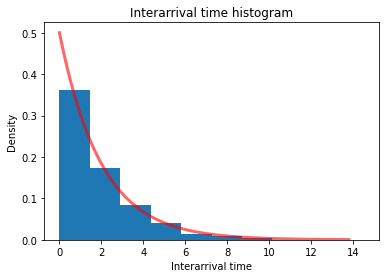

In [172]:
# Import exponential distribution function from scipy.stats
from scipy.stats import expon

# Set mean of this distribution to whatever we were using above for interarrival time
mean_interarrival_time = interarrival_time

# Create a random variable object based on the exponential distribution with the given mean
rv_expon = expon(scale=mean_interarrival_time)



# Generate 1000 exponential random variates (Exponential function from numpy)
iat_sample = rg.exponential(mean_interarrival_time, 1000)

# Create a histogram of the random samples with exponential pdf overlaid
plt.title("Interarrival time histogram")
plt.xlabel("Interarrival time")
plt.ylabel("Density")
plt.hist(iat_sample, density=True);

# Create values for the x-axis using expon function from SciPy
x_expon = np.linspace(rv_expon.ppf(0.0001),
                rv_expon.ppf(0.999), 500)

# Create values for the y-axis
y_expon_pdf = rv_expon.pdf(x_expon)

plt.plot(x_expon, y_expon_pdf,
       'r-', lw=3, alpha=0.6, label='Exponential pdf');

Now, we can modify our vehicle arrivals function to use Poisson arrivals instead of equally-spaced arrivals.

In [173]:
def vehicle_arrivals_random_1(env, mean_interarrival_time=2.0, rg=default_rng(0)):
    """Generate vehicles according to a Poisson arrival process"""

    # Create a counter to keep track of the number of vehicles generated and to serve as unique vehicle id
    vehicle = 0

    # Infinite loop for generating vehicles
    while True:

        # Generate next interarrival time from exponential distribution
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of vehicles
        vehicle += 1
        
        print(f"Vehicle {vehicle} created at time {env.now}")

We can run this new model with random arrivals...

In [174]:
# Initialize a new simulation environment
env2 = simpy.Environment()

# Create a process generator and start it and add it to the env
# env.process() starts and adds it to env
runtime = 25
interarrival_time = 2.0
env2.process(vehicle_arrivals_random_1(env2, interarrival_time))

# Run the simulation
env2.run(until=runtime)

Vehicle 1 created at time 1.3598638079378191
Vehicle 2 created at time 3.3990580108695485
Vehicle 3 created at time 3.4386713360476593
Vehicle 4 created at time 3.4432099894101156
Vehicle 5 created at time 4.543895734688212
Vehicle 6 created at time 7.803776604004982
Vehicle 7 created at time 9.150942509339446
Vehicle 8 created at time 10.661545224990228
Vehicle 9 created at time 16.295117183141677


## Model 2: Simplified border crossing with one resource

In this next step we will add the limited resource of a custom's officer.  We need to aquire and release this resource

Our vehicles enter the system, yield until an officer is available, spend some time with the customs officer, prepare to leave (delay) and then exit customs

In [175]:
def simplified_customs_process(env, name, mean_officer_time, mean_postofficer_time, officer):
    """Process function modeling how a vehicle flows through system."""

    print(f"{name} entering border crossing at {env.now:.4f}")
    
    # Request customs officer
    with officer.request() as request:
        print(f"{name} requested customs officer at {env.now:.4f}")
        yield request
        print(f"{name} got officer at {env.now:.4f}")
        yield env.timeout(rg.normal(mean_officer_time, 0.4))
                          
    # Yield for the post-officer time - time to put documents away, buckle seat belts, and pull away
    yield env.timeout(mean_postofficer_time)
    
    # The process is over, vehicle exits the border crossing
    print(f"{name} exiting border crossing at {env.now:.4f}")

We need to register the yield as a process...

In [176]:
def vehicle_arrivals_random_2(env, mean_interarrival_time, mean_officer_time,
                              mean_postofficer_time, officer, rg=default_rng(0)):
    """Generate vehicles according to a Poisson arrival process"""

    # Create a counter to keep track of number of vehicles generated and to serve as unique vehicle id
    vehicle = 0

    # Infinite loop for generating vehicles
    while True:

        # Generate next interarrival time
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # Update counter of vehicles
        vehicle += 1

        print(f"Vehicle{vehicle} created at time {env.now}")
               
        # Create and register the simplifed customs process        
        # Create a new vehicle delay process generator object.
        vehicle_visit = simplified_customs_process(env, 'Vehicle{}'.format(vehicle), 
                                                   mean_officer_time, mean_postofficer_time, officer)
        
        # Register the process with the simulation environment
        env.process(vehicle_visit)        

Create a new simulation environment and run our new model...

In [177]:
# Initialize a simulation environment
env3 = simpy.Environment()

# Set input values
mean_interarrival_time = 2.0
mean_officer_time = 5.0
mean_postofficer_time = .75
num_officers = 2

# Create officer resource
officer = simpy.Resource(env3, num_officers)

# Register our new arrivals process
env3.process(vehicle_arrivals_random_2(env3, mean_interarrival_time, mean_officer_time,
                                       mean_postofficer_time, officer))

# Run the simulation
runtime = 50
env3.run(until=runtime)

Vehicle1 created at time 1.3598638079378191
Vehicle1 entering border crossing at 1.3599
Vehicle1 requested customs officer at 1.3599
Vehicle1 got officer at 1.3599
Vehicle2 created at time 3.3990580108695485
Vehicle2 entering border crossing at 3.3991
Vehicle2 requested customs officer at 3.3991
Vehicle2 got officer at 3.3991
Vehicle3 created at time 3.4386713360476593
Vehicle3 entering border crossing at 3.4387
Vehicle3 requested customs officer at 3.4387
Vehicle4 created at time 3.4432099894101156
Vehicle4 entering border crossing at 3.4432
Vehicle4 requested customs officer at 3.4432
Vehicle5 created at time 4.543895734688212
Vehicle5 entering border crossing at 4.5439
Vehicle5 requested customs officer at 4.5439
Vehicle3 got officer at 6.8962
Vehicle1 exiting border crossing at 7.6462
Vehicle6 created at time 7.803776604004982
Vehicle6 entering border crossing at 7.8038
Vehicle6 requested customs officer at 7.8038
Vehicle4 got officer at 8.7130
Vehicle7 created at time 9.1509425093

Super happy that worked... there were some tense moments! lol

## Create a `BorderCrossing` class

Time to start building some objects to stream line things.  As a reminder, this model assumes the following border crossing/customs process:

```
Arrival --> Primary Inspection --> Secondary Inspection (if needed) -->  Exit
```

I am going to start by hard coding some things.  I will circle back later to fine tune

In [178]:
class BorderCrossing(object):
    def __init__(self, env, num_officers, num_officers2, rg):
        # Simulation environment
        self.env = env
        self.rg = rg
        
        # Create list to hold timestamps dictionaries (one per vehicle)
        self.timestamps_list = []
        # Create lists to hold occupancy tuples (time, occ)
        self.insp1_occupancy_list = [(0.0, 0.0)]
        self.insp2_occupancy_list = [(0.0, 0.0)]
        
        # Create resources
        self.officer = simpy.Resource(env, num_officers)
        self.officer2 = simpy.Resource(env, num_officers2)


    # Create process methods - hard coding processing time distributions for now
    # TODO - remove hard coding
    # The vehicle argument is just a unique integer number

    def primary_inspect(self, vehicle):
        yield self.env.timeout(self.rg.normal(5.0, 1))
        
    def secondary_inspect(self, vehicle):
        yield self.env.timeout(self.rg.normal(15, 2.5))
    
    def prepare_to_leave(self, vehicle):
        yield self.env.timeout(self.rg.normal(0.75, .1))

## Create a `go_thru_customs` function

The `go_thru_customs` function will define the sequence of steps traversed by vehicles. It will also capture timestamps to make it easy to compute various system performance measures such as vehicle waiting times, queue sizes and resource utilization. The inputs to this function include:

* the simulation environment
* a vehicle id
* the border crossing object (created from the `BorderCrossing` class)
* the percentage of vehicles that typically get pulled aside for a secondary inspection
* the random number generator

In [179]:
def go_thru_customs(env, vehicle, crossing, pct_2nd_inspect, rg):
    # Vehicle arrives to crossing - note the arrival time
    arrival_ts = env.now
    

    # Reminder for Micki...by using request() in a context manager, we'll automatically release the resource when done

    # Request customs officer for primary inspection
    with crossing.officer.request() as request:
        yield request
        got_officer_ts = env.now
        # We got one! Update inspection 1 occupancy - increment by 1
        prev_occ = crossing.insp1_occupancy_list[-1][1]
        new_occ = (env.now, prev_occ + 1)
        crossing.insp1_occupancy_list.append(new_occ)
        yield env.process(crossing.primary_inspect(vehicle))
        release_officer_ts = env.now
        crossing.insp1_occupancy_list.append((env.now, crossing.insp1_occupancy_list[-1][1] - 1))


    # Request officer for 2nd inspection if needed
    if rg.random() < pct_2nd_inspect:
        with crossing.officer2.request() as request:
            yield request
            got_officer2_ts = env.now
            # Update inspection 2 occupancy - increment by 1
            prev_occ2 = crossing.insp2_occupancy_list[-1][1]
            new_occ2 = (env.now, prev_occ2 + 1)
            crossing.insp2_occupancy_list.append(new_occ2)            
            yield env.process(crossing.secondary_inspect(vehicle))
            release_officer2_ts = env.now
    else:
        got_officer2_ts = pd.NA
        release_officer2_ts = pd.NA
        
    exit_system_ts = env.now    
    #print(f"Vehicle {vehicle} exited at time {env.now}")

    # Create dictionary of timestamps
    timestamps = {'vehicle_id': vehicle,
                  'arrival_ts': arrival_ts,
                  'got_officer_ts': got_officer_ts,
                  'release_officer_ts': release_officer_ts,
                  'got_officer2_ts': got_officer2_ts,
                  'release_officer2_ts': release_officer2_ts,
                  'exit_system_ts': exit_system_ts}
    
    crossing.timestamps_list.append(timestamps)

## The `run_crossing` function

Now we need an additional function to run everything...

The inputs to this function include:

* the simulation environment
* the crossing object
* the mean vehicle interarrival time
* the percentage of vehicles that typically get pulled aside for a secondary inspection
* the random number generator
* stopping conditions for the simulation through either a stop time and a maximum number of vehicle arrivals

This function contains a `yield` statement, it is a generator and will need to be registered with the simulation environment.  We will do this from a main calling program.

In [180]:
def run_crossing(env, crossing, mean_interarrival_time, pct_2nd_inspect, rg, 
               stoptime=simpy.core.Infinity, max_arrivals=simpy.core.Infinity):
      
    # Create a counter to keep track of number of vehicles generated and to serve as unique vehicle id
    vehicle = 0

    # Loop for generating vehicles
    while env.now < stoptime and vehicle < max_arrivals:

        # Generate next interarrival time 
        iat = rg.exponential(mean_interarrival_time)
        
        # This process will now yield to a 'timeout' event. This process will resume after iat time units.
        yield env.timeout(iat)

        # New vehicle generated = update counter of vehicles
        vehicle += 1
        
        #print(f"Vehicle {vehicle} created at time {env.now}")

        env.process(go_thru_customs(env, vehicle, crossing, pct_2nd_inspect, rg))

Now we will create a `main` function that will serve as the entry point to using the simulation. This initial simulation runs for 480 time units

In [181]:
def main():
    
    # For now we are hard coding the vehicle arrival rate (vehicles per hour)
    vehicles_per_hour = 30
    mean_interarrival_time = 1.0 / (vehicles_per_hour / 60.0)
    # Percent of cars that get pulled over for 2nd inspection...
    pct_2nd_inspect = 0.10
    
    # Create a random number generator
    rg = default_rng(seed=2616)
    
    # For now we are going to hard code in the resource capacity levels 
    num_officers = 3
    num_officers2 = 2

    # Hours of operation
    stoptime = 480 # No more arrivals after this time
    
    # Create a simulation environment
    env = simpy.Environment()
    # Create a crossing to simulate
    crossing = BorderCrossing(env, num_officers, num_officers2, rg)
    
    # Register the run_crossing (generator) function
    env.process(run_crossing(env, crossing, mean_interarrival_time, pct_2nd_inspect, rg, stoptime=stoptime))
    # Actually run the simulation
    env.run()
    
    # The simulation is over now, create the output csv files from 
    # the dataframes created by running the simulation model.
    
    # Output log files 
    crossing_vehicle_log_df = pd.DataFrame(crossing.timestamps_list)
    crossing_vehicle_log_df.to_csv('./output/crossing_vehicle_log_df.csv', index=False)
    
    insp1_occupancy_df = pd.DataFrame(crossing.insp1_occupancy_list, columns=['ts', 'occ'])
    insp1_occupancy_df.to_csv('./output/insp1_occupancy_df.csv', index=False)
    
    insp2_occupancy_df = pd.DataFrame(crossing.insp2_occupancy_list, columns=['ts', 'occ'])
    insp2_occupancy_df.to_csv('./output/insp2_occupancy_df.csv', index=False)
    
 
    # Note simulation end time
    end_time = env.now
    print(f"Simulation ended at time {end_time}")
    return (end_time)

Crossing my fingers, it's time to run it.

Jupyter Lab needs emoji's to express the terror I feel lol

In [182]:
crossing_end_time = main()

Simulation ended at time 491.7046056613867


Well... not surprisingly, it did not work at first.  There were some tense moments... However, I finally noticed an important cell was marked as markdown and not active (I won't make that mistake again!), and performed some careful tweaking it looks like it ran!  Woo hoo!

## Post-processing the timestamps file

With any luck, this simulation model captured numerous timestamps for each vehicle as they went through the border crossing process. The timestamps were written to a log file with one row per vehicle. Now we can compute various wait times and service times for each vehicle and summarize them for the border crossing.

In [183]:
crossing_vehicle_log_df = pd.read_csv('./output/crossing_vehicle_log_df.csv')
crossing_vehicle_log_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   vehicle_id           263 non-null    int64  
 1   arrival_ts           263 non-null    float64
 2   got_officer_ts       263 non-null    float64
 3   release_officer_ts   263 non-null    float64
 4   got_officer2_ts      24 non-null     float64
 5   release_officer2_ts  24 non-null     float64
 6   exit_system_ts       263 non-null    float64
dtypes: float64(6), int64(1)
memory usage: 14.5 KB


In [184]:
crossing_vehicle_log_df.head()

,vehicle_id,arrival_ts,got_officer_ts,release_officer_ts,got_officer2_ts,release_officer2_ts,exit_system_ts
0,1,0.345456,0.345456,5.873448,NaN,NaN,5.873448
1,2,2.557598,2.557598,7.061028,NaN,NaN,7.061028
2,3,4.037005,4.037005,9.765394,NaN,NaN,9.765394
3,7,9.080142,9.765394,13.541706,NaN,NaN,13.541706
4,5,7.213826,7.213826,13.624230,NaN,NaN,13.624230


At first glance it looks like there is very little waiting for our lucky vehicle passengers. 

We can know for sure by computing any duration of interest as the difference between two timestamps. For example, the total time in the system is just the `exit_system_ts` minus the `arrival_ts`.

The following creates a function to calculate those wait times...

In [185]:
def compute_durations(timestamp_df):
    
    timestamp_df['wait_for_1st_inspect'] = timestamp_df.loc[:, 'got_officer_ts'] - timestamp_df.loc[:, 'arrival_ts']
    timestamp_df['1st_inspect_time'] = timestamp_df.loc[:, 'release_officer_ts'] - timestamp_df.loc[:, 'got_officer_ts']
    timestamp_df['wait_for_2nd_inspect'] = timestamp_df.loc[:, 'got_officer2_ts'] - timestamp_df.loc[:, 'release_officer2_ts']
    timestamp_df['2nd_inspect_time'] = timestamp_df.loc[:, 'release_officer2_ts'] - timestamp_df.loc[:, 'got_officer2_ts']    
    timestamp_df['time_at_border'] = timestamp_df.loc[:, 'exit_system_ts'] - timestamp_df.loc[:, 'arrival_ts']
    
    return timestamp_df

In [186]:
crossing_vehicle_log_df = compute_durations(crossing_vehicle_log_df)
crossing_vehicle_log_df

,vehicle_id,arrival_ts,got_officer_ts,release_officer_ts,got_officer2_ts,release_officer2_ts,exit_system_ts,wait_for_1st_inspect,1st_inspect_time,wait_for_2nd_inspect,2nd_inspect_time,time_at_border
0,1,0.345456,0.345456,5.873448,NaN,NaN,5.873448,0.000000,5.527992,NaN,NaN,5.527992
1,2,2.557598,2.557598,7.061028,NaN,NaN,7.061028,0.000000,4.503431,NaN,NaN,4.503431
2,3,4.037005,4.037005,9.765394,NaN,NaN,9.765394,0.000000,5.728389,NaN,NaN,5.728389
3,7,9.080142,9.765394,13.541706,NaN,NaN,13.541706,0.685252,3.776311,NaN,NaN,4.461563
4,5,7.213826,7.213826,13.624230,NaN,NaN,13.624230,0.000000,6.410404,NaN,NaN,6.410404
...,...,...,...,...,...,...,...,...,...,...,...,...
258,260,477.784768,479.683176,485.976654,NaN,NaN,485.976654,1.898409,6.293478,NaN,NaN,8.191887
259,261,478.448179,482.061419,487.613794,NaN,NaN,487.613794,3.613240,5.552375,NaN,NaN,9.165615
260,262,479.068334,483.966841,489.515134,NaN,NaN,489.515134,4.898508,5.548293,NaN,NaN,10.446800
261,256,470.555415,473.906553,479.683176,479.683176,490.907206,490.907206,3.351137,5.776624,-11.22403,11.22403,20.351791


### Histgram of total time in system

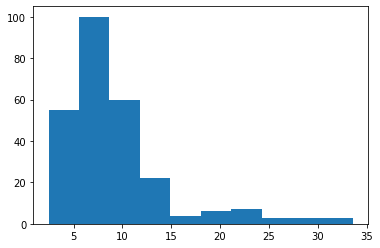

In [187]:
plt.hist(crossing_vehicle_log_df['time_at_border']);

### Key summary stats

In [188]:
crossing_vehicle_log_df.loc[:, ['wait_for_1st_inspect', 'wait_for_2nd_inspect', 'time_at_border']].describe()

,wait_for_1st_inspect,wait_for_2nd_inspect,time_at_border
count,263.000000,24.000000,263.000000
mean,2.837341,-15.008626,9.305474
std,2.453165,2.899089,5.457844
min,0.000000,-19.154517,2.431004
25%,0.731171,-17.829654,5.837475
50%,2.292628,-14.894877,7.803660
75%,4.408437,-13.151299,10.345051
max,10.485725,-8.534545,33.600668


So we are overstaffed, underestimating vehicles, or... it's COVID times at my border crossing lol

### Occupancy statistics

In [189]:
insp1_occupancy_df = pd.read_csv('./output/insp1_occupancy_df.csv')
insp2_occupancy_df = pd.read_csv('./output/insp2_occupancy_df.csv')

insp1_occupancy_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 527 entries, 0 to 526
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   ts      527 non-null    float64
 1   occ     527 non-null    float64
dtypes: float64(2)
memory usage: 8.4 KB


In [191]:
insp1_occupancy_df.iloc[250:275,]

,ts,occ
250,235.581010,2.0
251,235.581010,3.0
252,236.910991,2.0
253,236.910991,3.0
254,239.495481,2.0
255,239.495481,3.0
256,240.558372,2.0
257,240.558372,3.0
258,242.001736,2.0
259,242.001736,3.0
